In [1]:
from src import *
import seaborn as sns

In [2]:
from nilearn.connectome import ConnectivityMeasure
from brainspace.gradient import GradientMaps

## Description

We visualize joints plots fo 1st and 2nd eigenvectors of affinity matrices (i.e Gradients) and visualize their projection on cortical sufaces. 

GOAL: Joint plot 1st and 2nd connectivity gradients to visualize general topology and unimodal/transmodal distributions during rest and movie watching.

## Table of Contents
- [Single Video Processing](#single)
    - Functional Connectivity Matrix and Gradient Computation
    - Joint Plot 1st and 2nd Gradient
    - Visualization of Gradients on Cortical Surfaces


- [All Video Processing](#all)
    - Functional Connectivity Matrix and Gradient Computation
    - Joint Plot 1st and 2nd Gradient
    - Visualization of Gradients on Cortical Surfaces

In [3]:
mri_path = "./data/fmri_compile.csv"
mri_df   = pd.read_csv(mri_path)

<a class="anchor" id="single"></a>
#### Single Video Processing

Functional Connectivity Matrix and Gradient computation

In [4]:
correlation_measure = ConnectivityMeasure(kind='correlation')

filename_movie = 'TC_400_sub-S09_ses-4_Sintel.csv'
filename_rest  = 'TC_400_sub-S23_ses-1_Rest.csv'

movie_series, movie_df = df_to_timeseries(mri_df, filename_movie)
rest_series, rest_df   = df_to_timeseries(mri_df, filename_rest)

# trim the washimg time for movies before and after
wash  = 90 / TR # duration in seconds for wash is 90 sec
onset = 6 / TR # duration of onset is assumed to be 6 sec
front_pad, bot_pad = int(wash + onset), int(wash - onset)
movie_series       = movie_series[front_pad : -bot_pad]

fc_movie = correlation_measure.fit_transform([movie_series])[0]
fc_rest  = correlation_measure.fit_transform([rest_series])[0]

In [5]:
# ## NOTE: Perhaps do some re-ordering of labels, for now I don't know what to group
# # useful for plotting connectivity interactions on glass brain
# from nilearn import plotting
# plotting.plot_matrix(fc_movie, title="Movie Correlation Matrix", figure=(5,5), vmax=1, vmin=-1)
# plotting.plot_matrix(fc_rest, title="Rest Correlation Matrix", figure=(5,5), vmax=1, vmin=-1)

In [6]:
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99


g_rest  = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
g_rest.fit(fc_rest)

g_movie = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs, alignment=align_meth)
g_movie.fit(fc_movie, reference=g_rest.gradients_)

print("Alignement score movies on rests': {}".format(procrustes_score(g_rest.gradients_, g_movie.aligned_)))

Alignement score movies on rests': 63.856028605393334


In [7]:
# # Uncomment for: Sanity Check of Eigenvector explained variances
# plot_eigenvector_importance(g_movie)
# plot_eigenvector_importance(g_rest)

Joint Plot of 1st and 2nd Gradient

In [8]:
partial_region_movie = { k: movie_df[movie_df.vindex == k]['partial_region'].iloc[0]
                    for k in movie_df['vindex'].unique()}
partial_region_rest  = { k: rest_df[rest_df.vindex == k]['partial_region'].iloc[0]
                    for k in rest_df['vindex'].unique()}                    

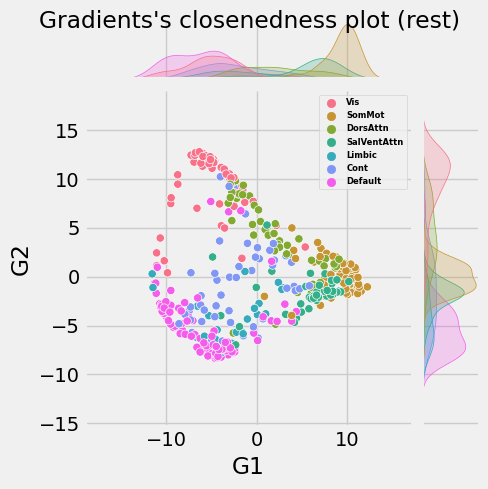

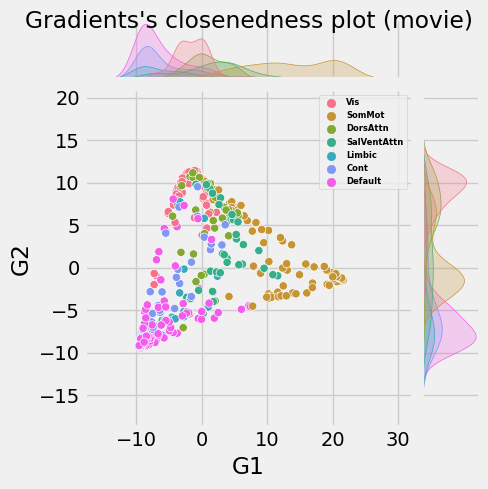

In [11]:
coloring  = [partial_region_movie[i] for i in range(400)]

gs = [g_rest, g_movie]
ts = ['rest', 'movie']
for i in range(2):
    if i == 0:
        tmp_df = {"G1":gs[i].gradients_[:,0] , "G2": gs[i].gradients_[:,1], "region": coloring}
    else:
        tmp_df = {"G1":gs[i].aligned_[:,0] , "G2": gs[i].aligned_[:,1], "region": coloring}
    ax     = sns.jointplot(data=tmp_df, x="G1", y="G2", hue="region", height=5)
    ax.fig.suptitle("Gradients's closenedness plot ({})".format(ts[i]))
    legend_properties = {'weight':'bold','size':6}
    ax.ax_joint.legend(prop=legend_properties,loc='upper right')


Visualization of Yeo-7 Parcellation on cortical surface
- We currently do the assumption that the labelling of cortical surfaces from `brainspace conte69` are of the same order as the one we currently 

In [4]:
# from brainspace.plotting import plot_hemispheres
# from brainspace.utils.parcellation import map_to_labels
# from brainspace.datasets import load_group_fc, load_parcellation, load_conte69

# labeling         = load_parcellation('schaefer', scale=400, join=True)
# surf_lh, surf_rh = load_conte69()

# mask = labeling != 0
# gs   = [g_rest, g_movie]
# grad = [None] * 4
# for i in range(2):
#     for k in range(2):
#         # map the gradient to the parcels
#         grad[i*2+k] = map_to_labels(gs[i].gradients_[:, k], labeling, mask=mask, fill=np.nan)

# plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 600), cmap='viridis_r',
#                  color_bar=True, label_text=['Grad1-Rest', 'Grad2-Rest', 'Grad1-Movie', 'Grad2-Movie'], zoom=1.55, embed_nb=True, interactive=False)

<a class="anchor" id="all"></a>
### Multiple concatenated

Functional Connectivity Matrix and Gradient computation

In [12]:
movies = [m for m in mri_df.filename.unique() if "Sintel" in m]
rests  = [m for m in mri_df.filename.unique() if "Sintel" not in m]

In [13]:
# trim the washimg time for movies before and after
wash  = 90 / TR # duration in seconds for wash is 90 sec
onset = 6 / TR # duration of onset is assumed to be 6 sec
front_pad, bot_pad = int(wash + onset), int(wash - onset)

movie_series = []
rest_series  = []
for m in movies:
    tmp1, movie_df = df_to_timeseries(mri_df, m)
    tmp1    = tmp1[front_pad : -bot_pad]
    movie_series.append(tmp1)
for r in rests:
    tmp2, rest_df = df_to_timeseries(mri_df, r)
    rest_series.append(tmp2)

In [14]:
movies_series = np.concatenate(movie_series)
rests_series  = np.concatenate(rest_series)

In [15]:
correlation_measure = ConnectivityMeasure(kind='correlation')


embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

fc_movies = correlation_measure.fit_transform([movies_series])[0]
fc_rests  = correlation_measure.fit_transform([rests_series])[0]

g_rests  = GradientMaps(n_components=nb_comp, approach=embedding, 
                        kernel=aff_kernel, random_state=rs)
g_rests.fit(fc_rests)

# we fit movies' gradient onto rests'
g_movies = GradientMaps(n_components=nb_comp, approach=embedding, alignment=align_meth,
                        kernel=aff_kernel, random_state=rs)
g_movies.fit(fc_movies, reference=g_rests.gradients_)
print("Alignement score movies on rests': {}".format(procrustes_score(g_rests.gradients_, g_movies.aligned_)))

Alignement score movies on rests': 22.415497320338854


Joint Plot of 1st and 2nd Gradient

In [16]:
partial_region_movie = { k: movie_df[movie_df.vindex == k]['partial_region'].iloc[0]
                    for k in movie_df['vindex'].unique()}
partial_region_rest  = { k: rest_df[rest_df.vindex == k]['partial_region'].iloc[0]
                    for k in rest_df['vindex'].unique()}                    

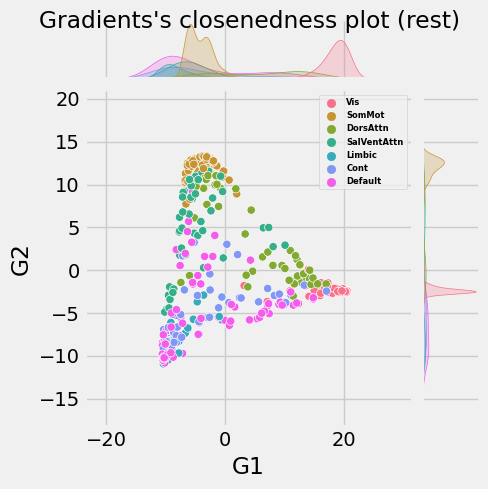

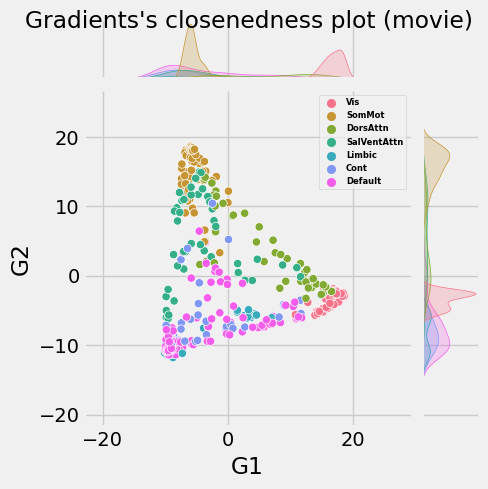

In [17]:
coloring  = [partial_region_movie[i] for i in range(400)]

gs = [g_rests, g_movies]

ts = ['rest', 'movie']
for i in range(2):
    # we keep exact same coloring method: same encoding
    if i == 0:
        tmp_df = {"G1":gs[i].gradients_[:,0] , "G2": gs[i].gradients_[:,1], "region": coloring}
    else:
        tmp_df = {"G1":gs[i].aligned_[:,0] , "G2": gs[i].aligned_[:,1], "region": coloring}
    ax     = sns.jointplot(data=tmp_df, x="G1", y="G2", hue="region", height=5)
    ax.fig.suptitle("Gradients's closenedness plot ({})".format(ts[i]))
    legend_properties = {'weight':'bold','size':6}
    ax.ax_joint.legend(prop=legend_properties,loc='upper right')


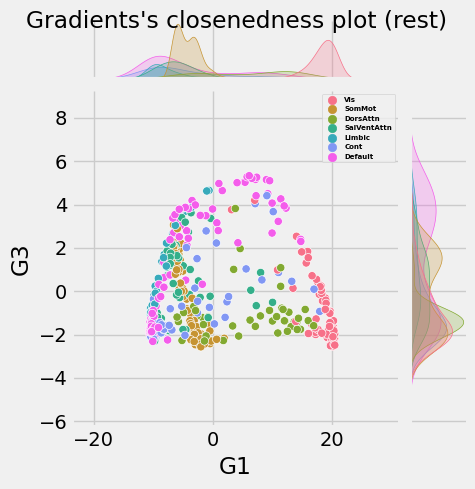

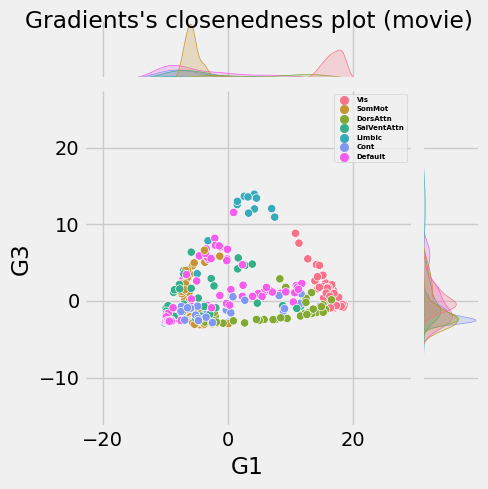

In [20]:
coloring  = [partial_region_movie[i] for i in range(400)]

gs = [g_rests, g_movies]

ts = ['rest', 'movie']
for i in range(2):
    # we keep exact same coloring method: same encoding
    if i == 0:
        tmp_df = {"G1":gs[i].gradients_[:,0] , "G3": gs[i].gradients_[:,2], "region": coloring}
    else:
        tmp_df = {"G1":gs[i].aligned_[:,0] , "G3": gs[i].aligned_[:,2], "region": coloring}
    ax     = sns.jointplot(data=tmp_df, x="G1", y="G3", hue="region", height=5)
    ax.fig.suptitle("Gradients's closenedness plot ({})".format(ts[i]))
    legend_properties = {'weight':'bold','size':5}
    ax.ax_joint.legend(prop=legend_properties,loc='upper right')


Visualization of Yeo-7 Parcellation on cortical surface
- We currently do the assumption that the labelling of cortical surfaces from `brainspace conte69` are of the same order as the one we currently 

/Users/michaelc.c.h/opt/miniconda3/envs/brain/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


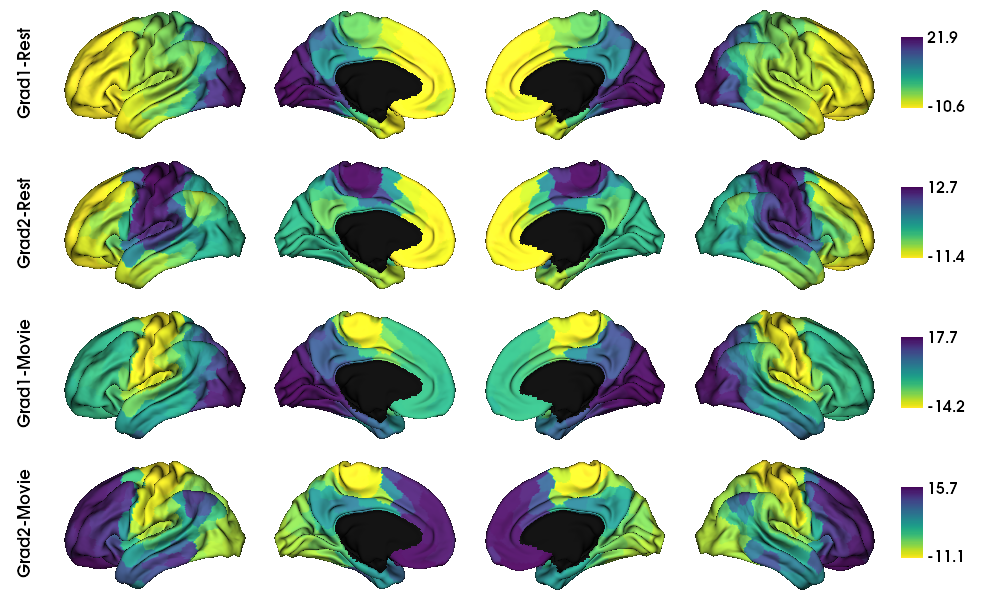

In [39]:
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()


mask = labeling != 0
gs   = [g_rests, g_movies]
grad = [None] * 4
for i in range(2):
    for k in range(2):
        # map the gradient to the parcels
        grad[i*2+k] = map_to_labels(gs[i].gradients_[:, k], labeling, mask=mask, fill=np.nan)

plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 600), cmap='viridis_r',
                 color_bar=True, label_text=['Grad1-Rest', 'Grad2-Rest', 'Grad1-Movie', 'Grad2-Movie'], zoom=1.55, embed_nb=True, interactive=False)
